In [37]:
import warnings, re, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_classif
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PowerTransformer, FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, HistGradientBoostingClassifier, BaggingClassifier

%matplotlib inline
%load_ext autoreload
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data after fill nan values process

In [38]:
data = pd.read_csv('../data/processed/preprocessed_data.csv', sep = "," , encoding = 'utf-8')
data.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.944960,266.0,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,500,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23,821000265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good


## Analyze distrubution

In [39]:
data.describe()

,Month,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,4.500000,119.509700,5.004617e+08,1.764157e+05,4188.592303,17.091280,22.47443,72.466040,10.761960,21.068780,30.898505,10.388188,26.222000,1426.220376,32.285173,221.207040,1403.118217,195.888840,400.446008
std,2.291299,684.757313,2.908267e+08,1.429618e+06,3180.036303,117.404834,129.05741,466.422621,61.789933,14.860104,222.891352,6.787190,183.476928,1155.129026,5.116875,99.679734,8306.041270,198.056716,213.056954
min,1.000000,14.000000,8.134900e+04,7.005930e+03,303.645417,-1.000000,0.00000,1.000000,0.000000,-5.000000,0.000000,-6.490000,0.000000,0.230000,20.000000,1.000000,0.000000,0.000000,0.007760
25%,2.750000,25.000000,2.451686e+08,1.945750e+04,1624.937917,3.000000,4.00000,8.000000,2.000000,10.000000,9.000000,5.330000,3.000000,566.072500,28.052567,144.000000,30.306660,73.120365,270.099963
50%,4.500000,34.000000,5.006886e+08,3.757861e+04,3087.595000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,219.000000,69.249473,129.785283,334.095895
75%,6.250000,42.000000,7.560027e+08,7.279092e+04,5947.364167,7.000000,7.00000,20.000000,6.000000,28.000000,18.000000,14.860000,9.000000,1945.962500,36.496663,302.000000,161.224249,238.081272,467.338016
max,8.000000,8698.000000,9.999934e+08,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,404.000000,82331.000000,1977.326102,1602.040519


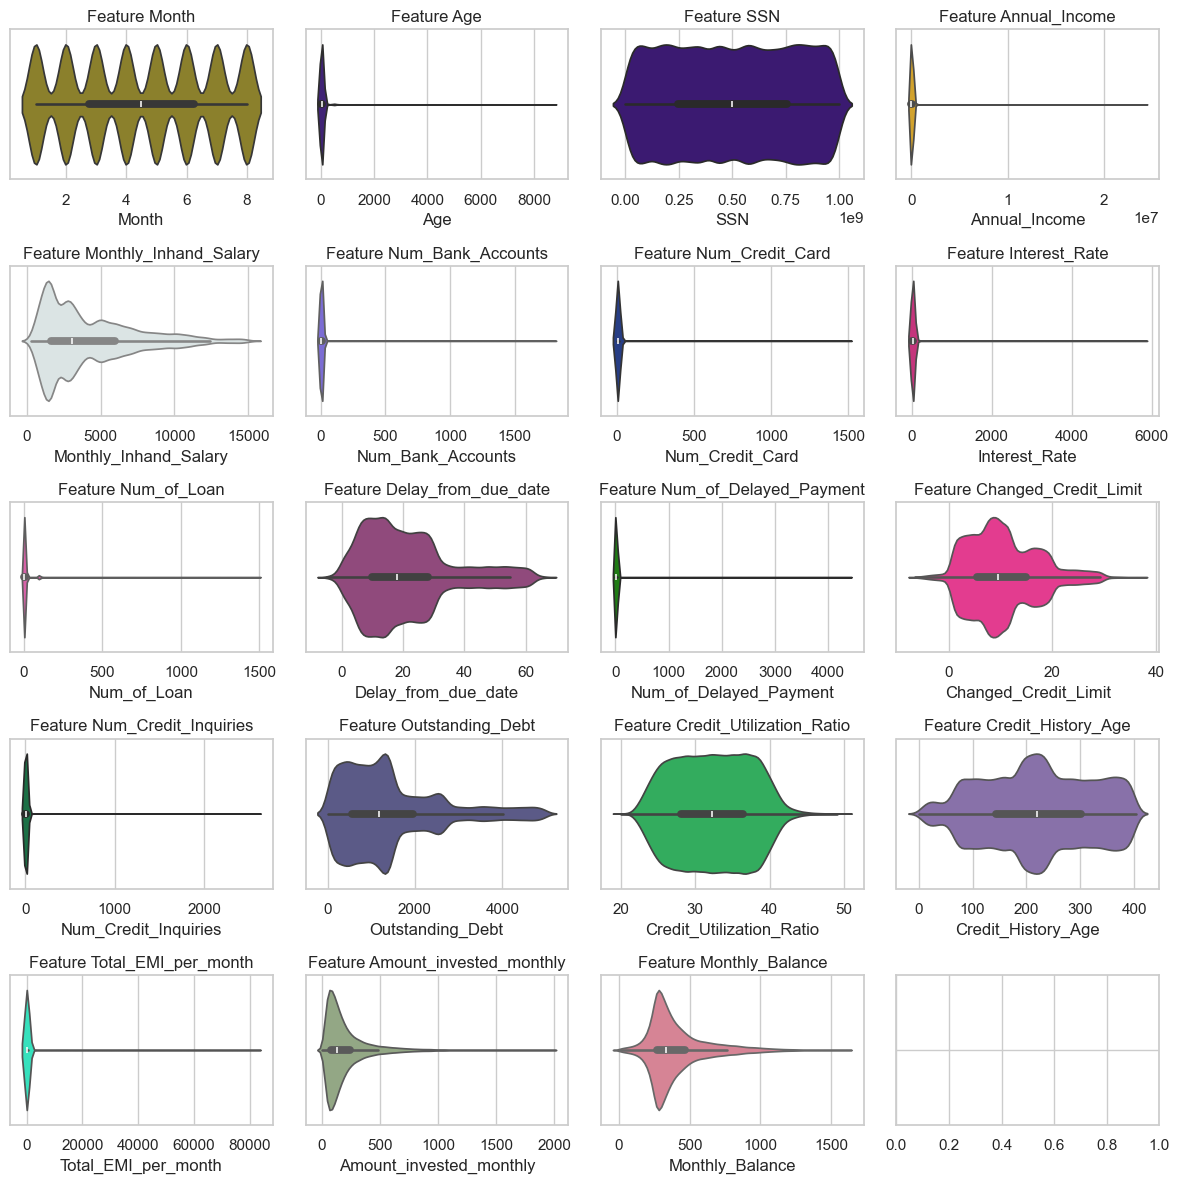

In [40]:
num_vars = data.select_dtypes(include=['number'])
sns.set(style='whitegrid')  
fig, axes = plt.subplots(5, 4, figsize=(12, 12), sharey=True) 

axes = axes.flatten()

for i, feature in enumerate(num_vars.columns):
    sns.violinplot(x=data[feature], ax=axes[i], color=np.random.rand(3,))  
    axes[i].set_title(f'Feature {feature}')  


plt.tight_layout()

plt.show()

## Age

In [41]:
data['Age'].describe()

count    100000.000000
mean        119.509700
std         684.757313
min          14.000000
25%          25.000000
50%          34.000000
75%          42.000000
max        8698.000000
Name: Age, dtype: float64

In [42]:
data[data['Age'] < 18]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
290,0x17b4,CUS_0x4080,3,ra Alperx,16,995378920,Mechanic,29469.98,2227.831667,7,...,Bad,3421.66,31.212269,160.0,Yes,69.685459,32.706652,High_spent_Large_value_payments,360.391056,Standard
291,0x17b5,CUS_0x4080,4,ra Alperx,16,995378920,Mechanic,29469.98,2227.831667,7,...,Bad,3421.66,33.298654,161.0,Yes,69.685459,27.250795,High_spent_Medium_value_payments,375.846913,Poor
292,0x17b6,CUS_0x4080,5,ra Alperx,16,995378920,Mechanic,29469.98,2227.831667,7,...,Bad,3421.66,38.177311,162.0,Yes,69.685459,71.264386,Low_spent_Medium_value_payments,361.833322,Poor
293,0x17b7,CUS_0x4080,6,ra Alperx,16,995378920,Mechanic,29469.98,2227.831667,7,...,Bad,3421.66,30.986998,163.0,Yes,69.685459,117.310316,Low_spent_Small_value_payments,325.787392,Poor
294,0x17b8,CUS_0x4080,7,ra Alperx,16,995378920,Mechanic,29469.98,2227.831667,7,...,Bad,3421.66,33.283061,164.0,Yes,69.685459,115.453416,Low_spent_Small_value_payments,327.644292,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99803,0x25ec9,CUS_0x1232,4,Lawderr,17,441261297,Developer,14937.49,1142.790833,8,...,Bad,3699.44,31.491509,161.0,Yes,50.960878,54.535301,Low_spent_Medium_value_payments,270.099963,Standard
99804,0x25eca,CUS_0x1232,5,Lawderr,17,441261297,Developer,14937.49,1142.790833,8,...,Bad,3699.44,38.797247,162.0,Yes,50.960878,120.038142,Low_spent_Medium_value_payments,270.099963,Standard
99805,0x25ecb,CUS_0x1232,6,Lawderr,17,441261297,Developer,14937.49,1142.790833,8,...,Bad,3699.44,30.027427,163.0,Yes,50.960878,76.540430,High_spent_Small_value_payments,270.099963,Standard
99806,0x25ecc,CUS_0x1232,7,Lawderr,17,441261297,Developer,14937.49,1142.790833,8,...,Bad,3699.44,24.812055,164.0,Yes,50.960878,100.625302,Low_spent_Medium_value_payments,270.099963,Standard


In [43]:
def replace_age(group):
    min_age = group['Age'].min()
    max_age = group['Age'].max()
    group['Age'] = group['Age'].apply(lambda x: min_age if x < 18 or x > 70 else x)
    return group

# Apply the function to the DataFrame using groupby and transform
data = data.groupby('Customer_ID').apply(replace_age).reset_index(drop=True)

## Annual income

In [44]:
data['Annual_Income'].describe()

count    1.000000e+05
mean     1.764157e+05
std      1.429618e+06
min      7.005930e+03
25%      1.945750e+04
50%      3.757861e+04
75%      7.279092e+04
max      2.419806e+07
Name: Annual_Income, dtype: float64

In [45]:
def replace_Annual_Income(group):
    min_Annual_Income = group['Annual_Income'].min()
    max_Annual_Income = group['Annual_Income'].max()
    group['Annual_Income'] = group['Annual_Income'].apply(lambda x: min_Annual_Income if  x > 0.2e+06 else x)
    return group

# Apply the function to the DataFrame using groupby and transform
data = data.groupby('Customer_ID').apply(replace_Annual_Income).reset_index(drop=True)

In [46]:
data['Annual_Income'].describe()

count    100000.000000
mean      50505.123449
std       38299.422093
min        7005.930000
25%       19342.972500
50%       36999.705000
75%       71683.470000
max      179987.280000
Name: Annual_Income, dtype: float64

## Monthly_Inhand_Salary

## Num_Bank_Accounts

In [47]:
data['Num_Bank_Accounts'].describe()

count    100000.000000
mean         17.091280
std         117.404834
min          -1.000000
25%           3.000000
50%           6.000000
75%           7.000000
max        1798.000000
Name: Num_Bank_Accounts, dtype: float64

In [48]:
data['Num_Bank_Accounts'] = data['Num_Bank_Accounts'].abs()
def replace_Num_Bank_Accounts(group):
    min_Num_Bank_Accounts = group['Num_Bank_Accounts'].min()
    max_Num_Bank_Accounts = group['Num_Bank_Accounts'].max()
    group['Num_Bank_Accounts'] = group['Num_Bank_Accounts'].apply(lambda x: min_Num_Bank_Accounts if x <1 or x > 20 else x)
    return group

# Apply the function to the DataFrame using groupby and transform
data = data.groupby('Customer_ID').apply(replace_Num_Bank_Accounts).reset_index(drop=True)

In [49]:
data['Num_Bank_Accounts'].describe()

count    100000.000000
mean          5.368980
std           2.593184
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          18.000000
Name: Num_Bank_Accounts, dtype: float64

## Num_Credit_Card

In [50]:
data['Num_Credit_Card'].describe()

count    100000.00000
mean         22.47443
std         129.05741
min           0.00000
25%           4.00000
50%           5.00000
75%           7.00000
max        1499.00000
Name: Num_Credit_Card, dtype: float64

In [51]:
def replace_Num_Credit_Card(group):
    min_Num_Credit_Card = group['Num_Credit_Card'].min()
    max_Num_Credit_Card = group['Num_Credit_Card'].max()
    group['Num_Credit_Card'] = group['Num_Credit_Card'].apply(lambda x: min_Num_Credit_Card if x <1 or x > 15 else x)
    return group

# Apply the function to the DataFrame using groupby and transform
data = data.groupby('Customer_ID').apply(replace_Num_Credit_Card).reset_index(drop=True)

In [52]:
data['Num_Credit_Card'].describe()

count    100000.000000
mean          5.533600
std           2.067683
min           0.000000
25%           4.000000
50%           5.000000
75%           7.000000
max          15.000000
Name: Num_Credit_Card, dtype: float64

## Interest_Rate

In [53]:
def replace_Interest_Rate(group):
    min_Interest_Rate = group['Interest_Rate'].min()
    max_Interest_Rate = group['Interest_Rate'].max()
    group['Interest_Rate'] = group['Interest_Rate'].apply(lambda x: min_Interest_Rate if x < 1 or x > 40 else x)
    return group

# Apply the function to the DataFrame using groupby and transform
data = data.groupby('Customer_ID').apply(replace_Interest_Rate).reset_index(drop=True)

In [54]:
data['Interest_Rate'].describe()

count    100000.00000
mean         14.53208
std           8.74133
min           1.00000
25%           7.00000
50%          13.00000
75%          20.00000
max          34.00000
Name: Interest_Rate, dtype: float64

## Num_Of_Loan

In [55]:
data[data['Num_of_Loan']>10]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
11,0x66a5,CUS_0x1009,4,Arunah,26,63676938,Mechanic,52312.68,4250.390000,6,...,Standard,202.68,24.996239,368.0,Yes,108.366467,171.450443,High_spent_Small_value_payments,405.222090,Standard
54,0x1f6e0,CUS_0x1018,7,Felsenthalq,15,731198119,Accountant,61194.81,5014.567500,7,...,Bad,2773.09,25.120102,170.0,Yes,225.368691,200.294654,Low_spent_Medium_value_payments,355.793405,Poor
101,0x21d8b,CUS_0x1038,6,B.h,27,355007832,Architect,129473.16,10959.430000,3,...,Standard,568.21,36.833587,238.0,Yes,255.327905,893.818725,Low_spent_Large_value_payments,216.796370,Standard
128,0x188be,CUS_0x1048,1,Janet McGurtyg,26,808812470,Accountant,42387.54,3680.295000,3,...,Standard,1835.67,34.096311,113.0,Yes,225.883369,376.154577,Low_spent_Medium_value_payments,45.991554,Poor
150,0x2130,CUS_0x104e,7,Kentaros,50,837935062,Teacher,19180.87,1688.405833,8,...,Standard,1127.57,37.747361,301.0,No,57.364211,67.916771,Low_spent_Small_value_payments,333.559602,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99852,0x1208e,CUS_0xfb6,5,Leah Schnurrj,21,668256453,Accountant,42165.91,3658.825833,4,...,Good,981.66,33.942602,365.0,No,0.000000,75.955391,High_spent_Large_value_payments,529.927192,Standard
99881,0x19183,CUS_0xfcb,2,Patrick Temple-Westk,24,765352455,Lawyer,10805.56,627.463333,5,...,Standard,298.98,28.605417,210.0,No,13.161860,71.599293,Low_spent_Small_value_payments,267.985180,Standard
99898,0x1d06c,CUS_0xfd1,3,Frewy,31,389556408,Architect,78666.57,6485.547500,4,...,Standard,1498.70,35.767532,264.0,No,247.851145,189.528371,Low_spent_Medium_value_payments,491.175234,Standard
99927,0x1fec1,CUS_0xfdf,8,Zhua,56,99844997,Mechanic,70114.38,5679.865000,0,...,Good,918.89,40.434529,301.0,No,131.472173,146.860002,High_spent_Large_value_payments,529.654325,Standard


In [56]:
def replace_Num_of_Loan(group):
    min_Num_of_Loan = group['Num_of_Loan'].min()
    max_Num_of_Loan = group['Num_of_Loan'].max()
    group['Num_of_Loan'] = group['Num_of_Loan'].apply(lambda x: min_Num_of_Loan if x <1 or x > 10 else x)
    return group

# Apply the function to the DataFrame using groupby and transform
data = data.groupby('Customer_ID').apply(replace_Num_of_Loan).reset_index(drop=True)

In [57]:
data['Num_of_Loan'].describe()

count    100000.000000
mean          3.532880
std           2.446356
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max           9.000000
Name: Num_of_Loan, dtype: float64

## Num_Of_Delayed_Payment

In [58]:
data['Num_of_Delayed_Payment'].describe()

count    100000.000000
mean         30.898505
std         222.891352
min           0.000000
25%           9.000000
50%          14.000000
75%          18.000000
max        4397.000000
Name: Num_of_Delayed_Payment, dtype: float64

In [59]:
def replace_Num_of_Delayed_Payment(group):
    min_Num_of_Delayed_Payment = group['Num_of_Delayed_Payment'].min()
    max_Num_of_Delayed_Payment = group['Num_of_Delayed_Payment'].max()
    group['Num_of_Delayed_Payment'] = group['Num_of_Delayed_Payment'].apply(lambda x: min_Num_of_Delayed_Payment if x <1 or x > 40 else x)
    return group

# Apply the function to the DataFrame using groupby and transform
data = data.groupby('Customer_ID').apply(replace_Num_of_Delayed_Payment).reset_index(drop=True)

In [60]:
data['Num_of_Delayed_Payment'].describe()

count    100000.000000
mean         13.325213
std           6.262664
min           0.000000
25%           9.000000
50%          14.000000
75%          18.000000
max          34.000000
Name: Num_of_Delayed_Payment, dtype: float64

## Num_Credit_Inquiries

## Total_EMI_Per_Month

In [61]:
def replace_Total_EMI_per_month(group):
    min_Total_EMI_per_month = group['Total_EMI_per_month'].min()
    max_Total_EMI_per_month = group['Total_EMI_per_month'].max()
    group['Total_EMI_per_month'] = group['Total_EMI_per_month'].apply(lambda x: min_Total_EMI_per_month if x <1 or x > 400 else x)
    return group

# Apply the function to the DataFrame using groupby and transform
data = data.groupby('Customer_ID').apply(replace_Total_EMI_per_month).reset_index(drop=True)

In [62]:
data['Total_EMI_per_month'].describe()

count    100000.000000
mean         98.793647
std          98.376351
min           0.000000
25%          28.830800
50%          65.645774
75%         143.185801
max        1042.674209
Name: Total_EMI_per_month, dtype: float64

## Amount_Invested_Monthly

In [63]:
def replace_Amount_invested_monthly(group):
    min_Amount_invested_monthly = group['Amount_invested_monthly'].min()
    max_Amount_invested_monthly = group['Amount_invested_monthly'].max()
    group['Amount_invested_monthly'] = group['Amount_invested_monthly'].apply(lambda x: min_Amount_invested_monthly if x <1 or x > 800 else x)
    return group

# Apply the function to the DataFrame using groupby and transform
data = data.groupby('Customer_ID').apply(replace_Amount_invested_monthly).reset_index(drop=True)

In [64]:
data['Amount_invested_monthly'].describe()

count    100000.000000
mean        176.264024
std         150.669373
min           0.000000
25%          72.774053
50%         127.087701
75%         224.730130
max         799.845975
Name: Amount_invested_monthly, dtype: float64

## Final check

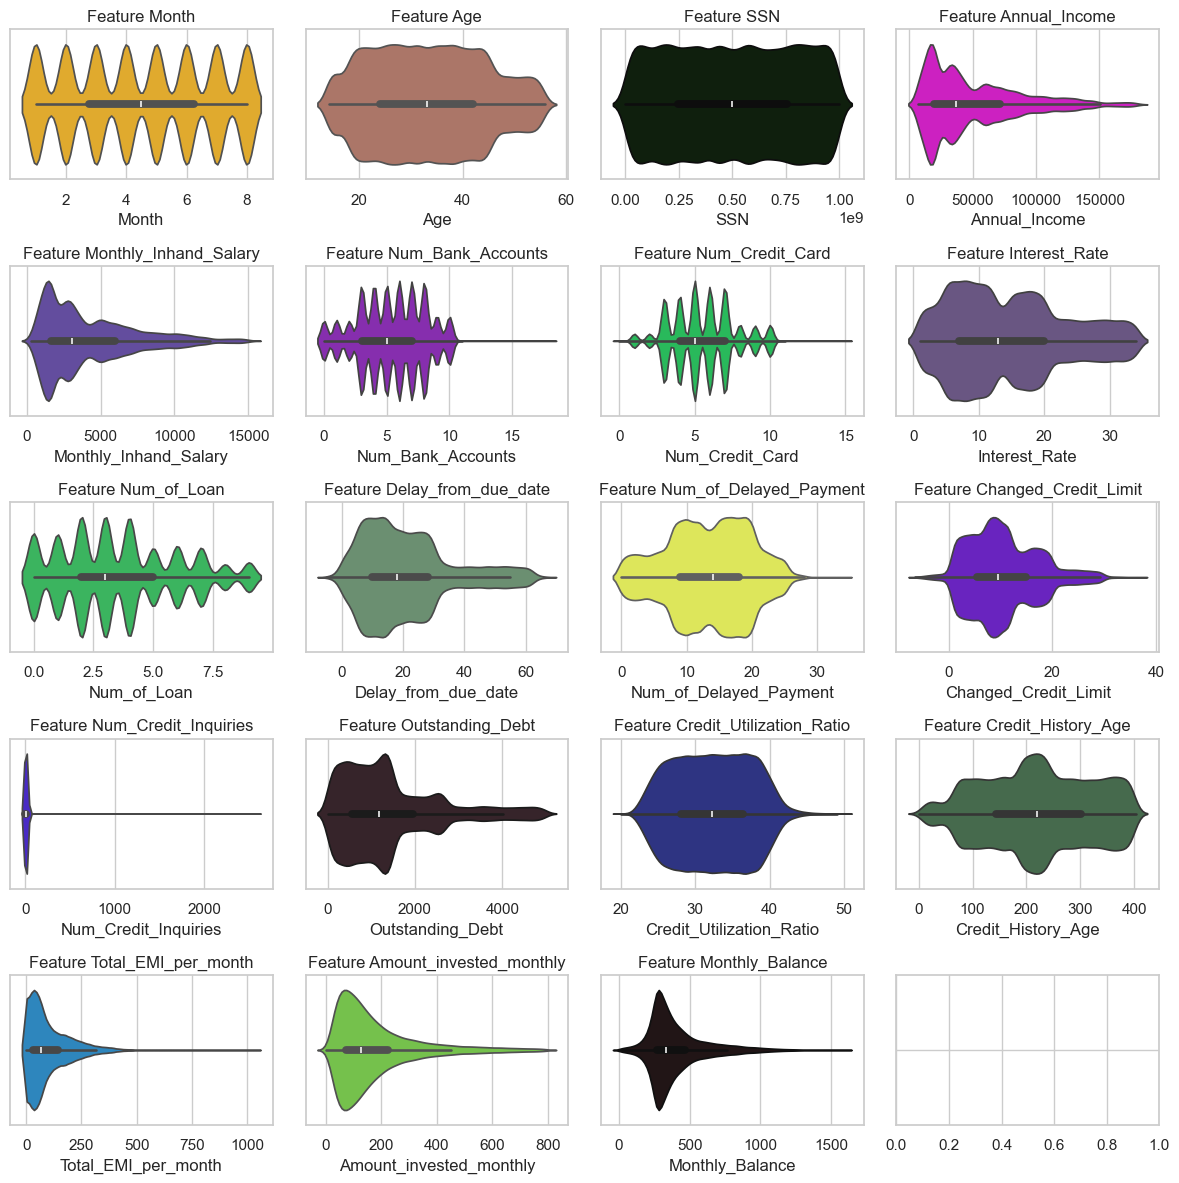

In [67]:
num_vars = data.select_dtypes(include=['number'])
sns.set(style='whitegrid')  
fig, axes = plt.subplots(5, 4, figsize=(12, 12), sharey=True) 

axes = axes.flatten()

for i, feature in enumerate(num_vars.columns):
    sns.violinplot(x=data[feature], ax=axes[i], color=np.random.rand(3,))  
    axes[i].set_title(f'Feature {feature}')  


plt.tight_layout()

plt.show()

In [66]:
data['Age'].describe()

count    100000.000000
mean         33.289140
std          10.788319
min          14.000000
25%          24.000000
50%          33.000000
75%          42.000000
max          56.000000
Name: Age, dtype: float64

In [68]:
data.to_csv('../data/interim/preprocessed_data.csv', index=False)